In [1]:
import logging
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from typing import Optional, List, Collection

from causalpy import Assignment
from causalpy.neural_networks import FCNet
from causalpy.causal_prediction.interventional import (
    AgnosticPredictor,
    MultiAgnosticPredictor,
)
from examples.study_cases import study_scm, generate_data_from_scm
import numpy as np
import torch
from plotly import graph_objs as go
from time import gmtime, strftime
import os

from tqdm import tqdm
import matplotlib.pyplot as plt


/home/michael/anaconda3/envs/causalpy/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [38]:
import itertools
from typing import Optional, Callable, Type, Tuple, List, Union

import torch
from causalpy.neural_networks.utils import get_jacobian
from abc import ABC, abstractmethod
import numpy as np


class CouplingBase(torch.nn.Module, ABC):
    def __init__(
        self,
        dim: int,
        dim_condition: int,
        nr_layers: int = 16,
        conditional_net: Optional[torch.nn.Module] = None,
        device: torch.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        ),
    ):
        super().__init__()
        self.device = device
        self.log_jacobian_cache = 0
        self.dim = dim
        self.dim_condition = dim_condition
        self.nr_layers = nr_layers
        self.nr_inverse_iters = 10

        # dummy buffers which become filled with parameters for the non conditional case.
        # otherwise these will hold the values given by the conditional net.
        self.mat_like_params = [
            torch.empty(1, self.dim, self.nr_layers),
            torch.empty(1, self.dim, self.nr_layers),
            torch.empty(1, self.dim, self.nr_layers),
        ]
        self.vec_like_params = [
            torch.empty(1, self.dim),  # bias2
            torch.empty(1, self.dim),  # eps
            torch.empty(1, self.dim),  # alpha
        ]

        self.is_conditional = dim_condition > 0
        if self.is_conditional:
            self.matrix_shape = (self.dim, self.nr_layers)
            self.bias_shape = (self.dim,)

            if conditional_net is None:
                self.conditional_net: torch.nn.Module = torch.nn.Sequential(
                    torch.nn.Linear(dim_condition, 50),
                    torch.nn.ReLU(),
                    torch.nn.Linear(50, 3 * dim * (nr_layers + 1)),
                )
            else:
                # conditional net needs to fulfill:
                # ( dimension in = dim_condition, dimension out = 3 * dim * (nr_layers + 1) )
                with torch.no_grad():
                    out = conditional_net(torch.ones(1, dim_condition))
                    assert out.size() == (1, 3 * dim * (nr_layers + 1),), (
                        f"Size mismatch: Conditional network needs to output size "
                        f"[batch_size, 3*dim*(nr_layers+1) = {3 * dim * (nr_layers + 1)}]. "
                        f"Provided was [out] = [{tuple([*out.size()])}]."
                    )
                self.conditional_net: torch.nn.Module = conditional_net
        else:
            # only in the case of no conditional neural network are these trainable parameters.
            # Otherwise their data will be provided by the condition generating network.
            self.reset_parameters()
            self.mat_like_params = torch.nn.ParameterList(
                [
                    torch.nn.Parameter(tensor, requires_grad=True)
                    for tensor in self.mat_like_params
                ]
            )
            self.vec_like_params = torch.nn.ParameterList(
                [
                    torch.nn.Parameter(tensor, requires_grad=True)
                    for tensor in self.vec_like_params
                ]
            )

    def reset_parameters(self):
        if self.is_conditional:
            with torch.no_grad():
                if isinstance(self.conditional_net, torch.nn.Sequential):
                    for layer in self.conditional_net:
                        if list(layer.parameters()):
                            # true if the layer has any parameters (e.g. false for a ReLu)
                            layer.reset_parameters()
                else:
                    # in case the net is external we expect it to have a reset parameters method.
                    self.conditional_net.reset_parameters()
        else:
            self._reset_conditional_parameters()

    def _reset_conditional_parameters(self):
        torch.manual_seed(5)
        with torch.no_grad():
            for mat in self.mat_like_params:
                mat.normal_(mean=0, std=1)
            # vec-like params
            self.bias2.normal_(mean=0, std=1)
            self.eps.fill_(value=.5)
            self.alpha.fill_(value=0)

    @property
    def mat1(self):
        return self.mat_like_params[0]

    @property
    def bias1(self):
        return self.mat_like_params[1]

    @property
    def mat2(self):
        return self.mat_like_params[2]

    @property
    def bias2(self):
        return self.vec_like_params[0]

    @property
    def eps(self):
        return self.vec_like_params[1]

    @property
    def alpha(self):
        return self.vec_like_params[2]

    def forward(
        self,
        x: torch.Tensor,
        condition: Optional[torch.Tensor] = None,
        reverse: bool = False,
    ):
        if self.is_conditional:
            self.set_conditional_params(condition)

        if not reverse:
            self.log_jacobian_cache = torch.log(self.transform_deriv(x))
            return self.transform(x)
        else:
            z = self.transform_inverse(x, nr_iters=self.nr_inverse_iters)
            self.log_jacobian_cache = -torch.log(self.transform_deriv(z))
            return z

    @abstractmethod
    def transform(self, x: torch.Tensor):
        raise NotImplementedError

    @abstractmethod
    def transform_deriv(self, x: torch.Tensor):
        raise NotImplementedError

    def transform_inverse(self, y: torch.Tensor, nr_iters=10):
        """
        Newton method for iterative approximation of the inverse g of the transformation f at point y: g(y).
        """
        yn = y  # * torch.exp(-self.alpha) - self.bias2
        with torch.no_grad():
            for i in range(nr_iters - 1):
                yn = yn - (self.transform(yn) - y) / self.transform_deriv(yn)
        return yn - (self.transform(yn) - y) / self.transform_deriv(yn)

    def set_conditional_params(self, condition: torch.Tensor):
        """
        In the case of a conditional INN set the parameters of the bijective map for the condition.

        Notes
        -----
        If this method was called although the INN is unconditional, uncaught errors will be raised.
        """
        assert (
            self.is_conditional
        ), "Conditional parameters can only be set when the INN is conditional. They are learned otherwise."
        size = condition.size(0)
        new_params = self.conditional_net(condition)

        begin = 0

        def reshape(param_list, new_shape):
            nonlocal begin
            for i, param in enumerate(param_list):
                # [1:] to ignore batch size (dim 0) of last run
                end = begin + np.prod(param.size()[1:])
                param_list[i] = torch.reshape(new_params[:, begin:end], new_shape)
                begin = end

        reshape(self.mat_like_params, (size,) + self.matrix_shape)
        reshape(self.vec_like_params, (size,) + self.bias_shape)

    def jacobian(self, x: Optional[torch.Tensor] = None, rev: bool = False):
        if x is None:
            return self.log_jacobian_cache
        else:
            return get_jacobian(self, x, dim_in=1, dim_out=1, device=self.device)


class CouplingMonotone(CouplingBase):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.elu = torch.nn.ELU()

    def activation_func(self, x):
        return self.elu(x)

    def activation_deriv(self, x):
        return 1 + self.activation_func(-torch.relu(-x))

    def transform(self, x):
        internal_sum = torch.sum(
            self.mat2
            * self.activation_func(
                x.unsqueeze(2).expand(-1, -1, self.nr_layers) * self.mat1 + self.bias1
            ),
            dim=2,
        )
        divisor = torch.sum(torch.relu(-self.mat1 * self.mat2), dim=2) + 1
        return (
            self.alpha.exp()
            * (x + 0.8 * torch.sigmoid(self.eps) * internal_sum / divisor)
            + self.bias2
        )

    def transform_deriv(self, x):
        internal_sum = torch.sum(
            self.activation_deriv(
                x.unsqueeze(2).expand(-1, -1, self.nr_layers) * self.mat1 + self.bias1
            )
            * self.mat1
            * self.mat2,
            dim=2,
        )
        divisor = torch.sum(torch.relu(-self.mat1 * self.mat2), dim=2) + 1
        return self.alpha.exp() * (
            1 + 0.8 * torch.sigmoid(self.eps) * internal_sum / divisor
        )


class CouplingGeneral(CouplingBase):
    @staticmethod
    def activation_func(x):
        # return torch.tanh(x)
        return torch.exp(-(x ** 2)) * 1.16

    @staticmethod
    def activation_deriv(x):
        # return 1 - self.activation_func(x) ** 2
        return -2 * x * CouplingGeneral.activation_func(x)

    def transform(self, x: torch.Tensor):
        internal_sum = torch.sum(
            self.activation_func(
                x.unsqueeze(2).expand(-1, -1, self.nr_layers) * self.mat1 + self.bias1
            )
            * self.mat2,
            dim=2,
        )
        divisor = torch.sum(torch.abs(self.mat1 * self.mat2), dim=2) + 1
        return (
            torch.exp(self.alpha)
            * (x + 0.8 * torch.sigmoid(self.eps) * internal_sum / divisor)
            + self.bias2
        )

    def transform_deriv(self, x: torch.Tensor):
        internal_sum = torch.sum(
            self.activation_deriv(
                x.unsqueeze(2).expand(-1, -1, self.nr_layers) * self.mat1 + self.bias1
            )
            * self.mat1
            * self.mat2,
            dim=2,
        )
        divisor = torch.sum(torch.abs(self.mat1 * self.mat2), dim=2) + 1
        return torch.exp(self.alpha) * (
            1 + 0.8 * torch.sigmoid(self.eps) * internal_sum / divisor
        )


class CINN(torch.nn.Module):
    def __init__(
        self,
        dim: int,
        dim_condition,
        nr_blocks: int = 3,
        nr_layers: int = 16,
        normalize_forward: bool = True,
        conditional_net: Optional[torch.nn.Module] = None,
        device: Union[str, torch.device] = "cuda"
        if torch.cuda.is_available()
        else "cpu",
    ):
        super().__init__()
        self.nr_blocks = nr_blocks

        # whether we pass through the network in the forward or backward direction for normalizing.
        self.normalize_forward = normalize_forward

        if conditional_net is not None:
            conditional_net = conditional_net.to(device)

        self.blocks = torch.nn.ModuleList([])
        for i in range(nr_blocks):
            self.blocks.append(
                CouplingGeneral(
                    dim=dim,
                    nr_layers=nr_layers,
                    dim_condition=dim_condition,
                    conditional_net=conditional_net,
                    device=device,
                )
            )
            self.blocks.append(
                CouplingMonotone(
                    dim=dim,
                    nr_layers=nr_layers,
                    dim_condition=dim_condition,
                    conditional_net=conditional_net,
                    device=device,
                )
            )
        self.log_jacobian_cache = torch.zeros(dim)

    def forward(
        self,
        x: torch.Tensor,
        condition: Optional[torch.Tensor] = None,
        reverse: bool = False,
    ):
        self.log_jacobian_cache = 0.0

        block_iter = self.blocks[::-1] if reverse else self.blocks
        for block in block_iter:
            x = block(x=x, condition=condition, reverse=reverse)
            self.log_jacobian_cache += block.jacobian()

        return x

    def normalizing_flow(
        self, target: torch.Tensor, condition: Optional[torch.Tensor] = None,
    ):
        """
        Transport the incoming target samples `x` under condition `condition` to the gauss distribution.
        This is referred to as the normalizing flow direction.

        Notes
        -----
        Whether normalizing is the forward pass or the inverse pass through the flow architecture is defined
        in the parameter `normalize_forward`.
        """
        return self(target, condition=condition, reverse=not self.normalize_forward)

    def generating_flow(
        self, normals: torch.Tensor, condition: Optional[torch.Tensor] = None,
    ):
        """
        Transport the incoming gaussian samples `x` under condition `condition` to the target distribution.
        This is referred to as the generating flow direction.

        Notes
        -----
        Whether normalizing is the forward pass or the inverse pass through the flow architecture is defined
        in the parameter `normalize_forward`.
        """
        return self(normals, condition=condition, reverse=self.normalize_forward)

    def jacobian(self, x: Optional[torch.Tensor], rev: bool = False):
        if x is None:
            return self.log_jacobian_cache
        else:
            return get_jacobian(
                self, x, dim_in=1, dim_out=1, device=self.device, rev=rev
            )

    def reset_parameters(self):
        for block in self.blocks:
            block.reset_parameters()


In [39]:

class CINNFC(torch.nn.Module, Assignment):
    def __init__(
        self,
        dim_in: int,
        nr_layers: int = 0,
        nr_blocks: int = 1,
        strength: float = 0.0,
        **kwargs
    ):
        super().__init__()
        Assignment.__init__(self)
        self.nr_layers = nr_layers
        self.dim_in = dim_in - 1
        self.strength = strength
        # -1 bc additive noise 
        self.cinn = CINN(dim=dim_in-1, dim_condition =0, nr_layers=nr_layers, nr_blocks=nr_blocks, device="cuda")


    def forward(self, *args, **kwargs):
        with torch.no_grad():
            noise = torch.from_numpy(np.array(list(args), dtype=np.float32).T).to(device).reshape(-1, 1)
            variables = torch.from_numpy(
                np.array(list(kwargs.values()), dtype=np.float32).T
            ).squeeze(0).to(device).reshape(noise.shape[0], -1)

            x = variables
#             print(noise.shape)
            if self.dim_in > 0:
                base = torch.cat((noise, variables), dim=1).to(device)
            else:
                base = noise
                
#             print("Baseshape", base.shape)
            
            if self.dim_in == 0:
                nonlin_part = noise
            else:
                ev = self.cinn(x)[:, 0].reshape(-1, 1)
#                 print("EV", ev.shape)
#                 print("NOise", noise.shape)
                nonlin_part = ev + noise
            
#             print("nonlin", nonlin_part.shape)

            base_sum = torch.sum(base, dim=1).view(-1, 1)
            
            x = nonlin_part * self.strength + (1 - self.strength) * base_sum

            return x.cpu().numpy().reshape(-1)


    def __len__(self):
        raise 2

    def function_str(self, variable_names: Optional[Collection[str]] = None):
        return f"CINN({', '.join(variable_names)})"



In [40]:
model = CINNFC
def fc_net(nr_layers: int, nr_hidden, strength: float, nr_blocks = 1, device="cuda"):
    network_params = {"nr_layers": nr_layers, "nr_blocks": nr_blocks, "nr_hidden": nr_hidden, 'strength': strength, 'device': device}
    nets = {
        "X_0": model(dim_in=1, **network_params).to(device),
        "X_1": model(dim_in=2,  **network_params).to(device),
        "X_2": model(dim_in=2,  **network_params).to(device),
        "X_3": model(dim_in=2,  **network_params).to(device),
        "X_4": model(dim_in=2,  **network_params).to(device),
        "X_5": model(dim_in=1,  **network_params).to(device),
        "X_6": model(dim_in=3,  **network_params).to(device),
        "X_7": model(dim_in=1,  **network_params).to(device),
        "Y": model(dim_in=3, **network_params).to(device),
    }
    return nets


In [41]:
def run_scenario(
    Predictor, params, sample_size, nr_runs, epochs, scenario, step, **kwargs
):
    seed = 0
    np.random.seed(seed)
    # print(coeffs)
    scm = study_scm(seed=seed)
    standard_sample = scm.sample(sample_size)
    print(scm)

    nets = fc_net(**params)
    scm.intervention(
        {
            "X_0": (None, nets["X_0"], None),
            "X_1": (None, nets["X_1"], None),
            "X_2": (None, nets["X_2"], None),
            "X_3": (None, nets["X_3"], None),
            "X_4": (None, nets["X_4"], None),
            "X_5": (None, nets["X_5"], None),
            "X_6": (None, nets["X_6"], None),
            "X_7": (None, nets["X_7"], None),
            "Y": (None, nets["Y"], None),
        }
    )
    scm.clear_intervention_backup()  # make the current intervention the standard
    print(scm)
    # scm.plot(alpha=1)
    # plt.show()
    (
        data,
        environments,
        scm,
        possible_parents,
        target_parents,
    ) = generate_data_from_scm(scm, target_var="Y", sample_size=sample_size, seed=seed)
    
    fig = plt.figure()
    plt.hist(
        standard_sample["Y"],
        color="green",
        label="Standard Linear",
        density=True,
        bins=200,
        alpha=0.5,
    )
    plt.hist(
        data["Y"],
        color="red",
        label=f"FC (L: {params['nr_layers']}, B: {params['nr_blocks']}, S: {params['strength']}) applied",
        density=True,
        bins=200,
        alpha=0.5,
    )

    plt.legend()
    return fig





Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 1.0 X_5	 [ N := Standard Normal ]
X_7 := f(N) = 1.0 N	 [ N := Standard Normal ]
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = CINN(N)	 [ N := Standard Normal ]
X_1 := f(N, X_0) = CINN(N, X_0)	 [ N := Standard Normal ]
X_2 := f(N, X_0) = CINN(N, X_0)	 [

Environment 2: Intervention on variable X_3 for value [0.12292057].
Environment 3: Intervention on variable X_2 for value [-2.43981072].
Environment 4: Intervention on variable X_5 for value [-2.73826673].
Environment 5: Intervention on variable X_6 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = CINN(N)	 [ N := Standard Normal ]
X_1 := f(N, X_0) = CINN(N, X_0)	 [ N := Standard Normal ]
X_2 := f(N, X_0) = CINN(N, X_0)	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = CINN(N, X_1, X_2)	 [ N := Standard Normal ]
X_3 := f(N, Y) = CINN(N, Y)	 [ N := Standard Normal ]
X_4 := f(N, X_3) = CINN(N, X_3)	 [ N := Standard Normal ]
X_5 := f(N) = CINN(N)	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = CINN(N, Y, X_5)	 [ N := Standard Normal ]
X_7 := f(N) = CINN(N)	 [ N := Standard Normal ]
Target Variable: Y
Actual Parents: X_1, X_2
Candidate P

Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 1.0 X_5	 [ N := Standard Normal ]
X_7 := f(N) = 1.0 N	 [ N := Standard Normal ]
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = CINN(N)	 [ N := Standard Normal ]
X_1 := f(N, X_0) = CINN(N, X_0)	 [ N := Standard Normal ]
X_2 := f(N, X_0) = CINN(N, X_0)	 [

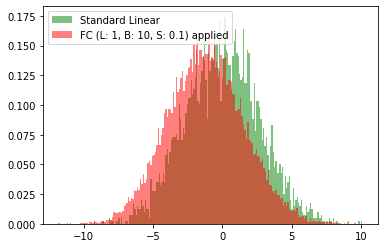

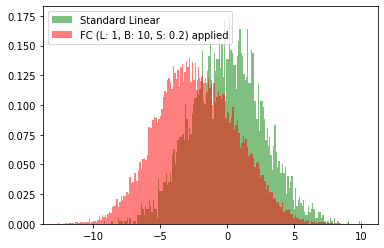

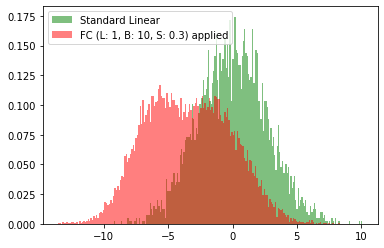

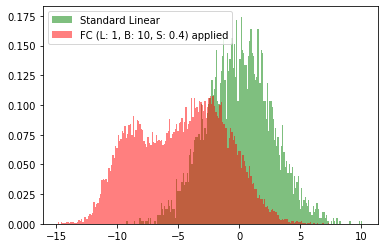

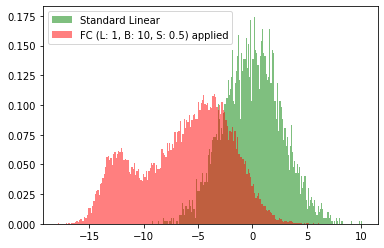

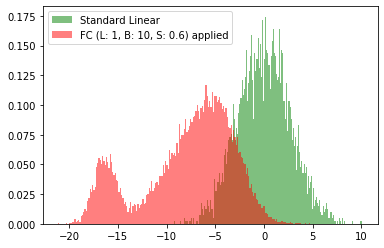

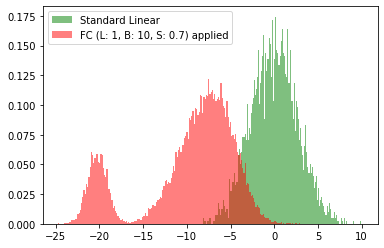

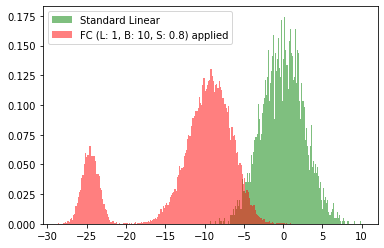

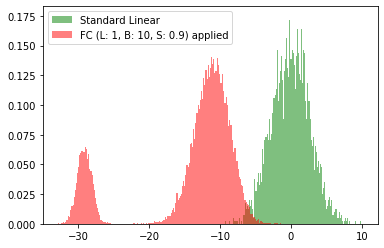

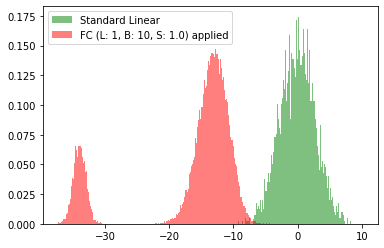

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if not os.path.isdir("./log"):
    os.mkdir("./log")
log_fname = f'{strftime("%Y-%m-%d_%H-%M-%S", gmtime())}'
logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    filename=f"./log/{log_fname}.log",
)  # pass explicit filename here
logger = logging.getLogger()  # get the root logger

PredictorClass = AgnosticPredictor
steps = 40
sample_size = 4096
nr_runs = 20
epochs = 1000
results = []
scenarios = ["parents", "children", "target", "all"]
# we test 4 scenarios:
# 1. increasing nonlinearity in the parents,
# 2. increasing nonlinearity in the children,
# 3. increasing nonlinearity on the target,
# 4. increasing nonlinearity on all
plots = []
scenario="all"
for step, (layers, strength) in enumerate(zip(range(0, steps, 4), range(steps))):
    plots.append(run_scenario(
    PredictorClass,
    {"nr_layers": 1, "nr_blocks": 10, "nr_hidden": 128, 'strength': (strength+1)*4/steps},
    nr_epochs=epochs,
    nr_runs=nr_runs,
    scenario=scenario,
    epochs=epochs,
    step=4*step,
    sample_size=sample_size))
